Samantha Townsend - EDA and Visualizations

In [2]:
# Import Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import zipfile
import os


Loading the dataset

In [3]:


zip_path = '/content/tpu-getting-started-20250620T182528Z-1-002.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Confirm extraction
for root, dirs, files in os.walk("/content"):
    for name in dirs:
        print(os.path.join(root, name))
    break


/content/.config
/content/tpu-getting-started
/content/drive
/content/sample_data


In [7]:
# This is the strictly functional code to reproduce the preprocessing steps from the Preprocessing notebook
## This cell block written by Emily
## Still looking into ways to export the data set but if you have the tpu-getting-started folder downloaded and in the project folder this code will run

## Function to decode and normalize the images and standardize to RGB
image_size = [512,512]

def decode_image(image_data):
    """Function to decode the image from the .tfrec"""
    ## Converts the raw JPEG file bytes into a 3D tensor, channels=3  indicates RGB, create the shape (height, width, 3), the output is a uint tensor with values 0-255
    image = tf.image.decode_jpeg(image_data, channels=3)

    ## Resize all images to the image size specified above [512,512], using bilinear method to smooth the images for efficient processing
    image = tf.image.resize(image, image_size, method = "bilinear")

    ## Converts the uint to float32, then normalizes the inputs by dividing by the number of pixel values 255
    image = tf.cast(image, tf.float32) / 255.0

    ## Takes the image size defined above this function and reshapes it to be the image size [height, width, 3]
    image = tf.reshape(image, [*image_size,3])
    return image

## Function to return an image, label pair for the training and validation sets
def read_labeled_tfrec(input_example):
    """Read and parse the labeled .tfrec"""
    ## Tells Tensorflow how to interpret the binary .tfrec data, "image" tells TF to expect binary jppeg bytes, "class" tells TF to expect integer labels (the flower labels)
    labeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    ## Parses the input_example using the format specified above
    ## Takes raw binary data (input_example) and uses the labeled_tfrec_format to return a dictionary {image bytes, flower label}
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)

    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])

    ## Process the label - input_example['class'] is the flower class ID
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

## Function to return an image without labels for the test set
def read_unlabeled_tfrec(input_example):
    """Read and parse the unlabeled .tfrec"""
    unlabeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)

    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])

    ## Process the label - input_example['id'] is the image ID
    image_id = input_example['id']
    return image, image_id

def load_dataset(filenames, labeled=True):
    """Load TFRecord dataset from filenames"""
    ## Creates a dataset that reads the files, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Creates a dataset of the raw binary .tfrec examples
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)

    ## dataset.map applies the read_labeled_tfrec function to each example, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Transforms the raw data to (image_tensor, label_int) pairs
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

## Combine all four image sizes into standardized datasets
image_size_folders = ['tfrecords-jpeg-192x192', 'tfrecords-jpeg-224x224', 'tfrecords-jpeg-331x331', 'tfrecords-jpeg-512x512']

## Initialize empty lists to collect all filenames from all image sizes
all_training_filenames = []
all_validation_filenames = []
all_test_filenames = []

## Collect filenames from all four image size folders
for folder in image_size_folders:
    train_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/train/*.tfrec")
    val_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/val/*.tfrec")
    test_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/test/*.tfrec")

    all_training_filenames.extend(train_files)
    all_validation_filenames.extend(val_files)
    all_test_filenames.extend(test_files)


## Creates standardized datasets with images from all four sizes
training_filenames = all_training_filenames
validation_filenames = all_validation_filenames
test_filenames = all_test_filenames

## Load and create the standardized training dataset
train_dataset = load_dataset(training_filenames, labeled=True)

## Load and create the standardized validation dataset
validation_dataset = load_dataset(validation_filenames, labeled=True)

## Load and create the standardized test dataset
test_dataset = load_dataset(test_filenames, labeled=False)

## Shuffling the training and validation sets
s
## Sets random seed for reproducability
tf.random.set_seed(42)

## Set shuffle buffer to set how many are shuffled at once
shuffle_buffer = 500

## Shuffle the training set
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## Shuffle the validation set
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## No shuffling of test data as it's not needed

NameError: name 's' is not defined

Load filenames from extracted folders

In [8]:
base_dir = "/content/tpu-getting-started"

sizes = ['tfrecords-jpeg-192x192', 'tfrecords-jpeg-224x224', 'tfrecords-jpeg-331x331', 'tfrecords-jpeg-512x512']
all_train_files = []

for size in sizes:
    path = os.path.join(base_dir, size, 'train')
    files = tf.io.gfile.glob(path + "/*.tfrec")
    all_train_files.extend(files)

print(f"Total training files: {len(all_train_files)}")

train_dataset = load_dataset(all_train_files, labeled=True)
train_dataset = train_dataset.shuffle(500, seed=42, reshuffle_each_iteration=False)


Total training files: 18


**EDA Visualizations**

 Class Distribution

/tmp/ipython-input-6-2343748040.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='viridis')


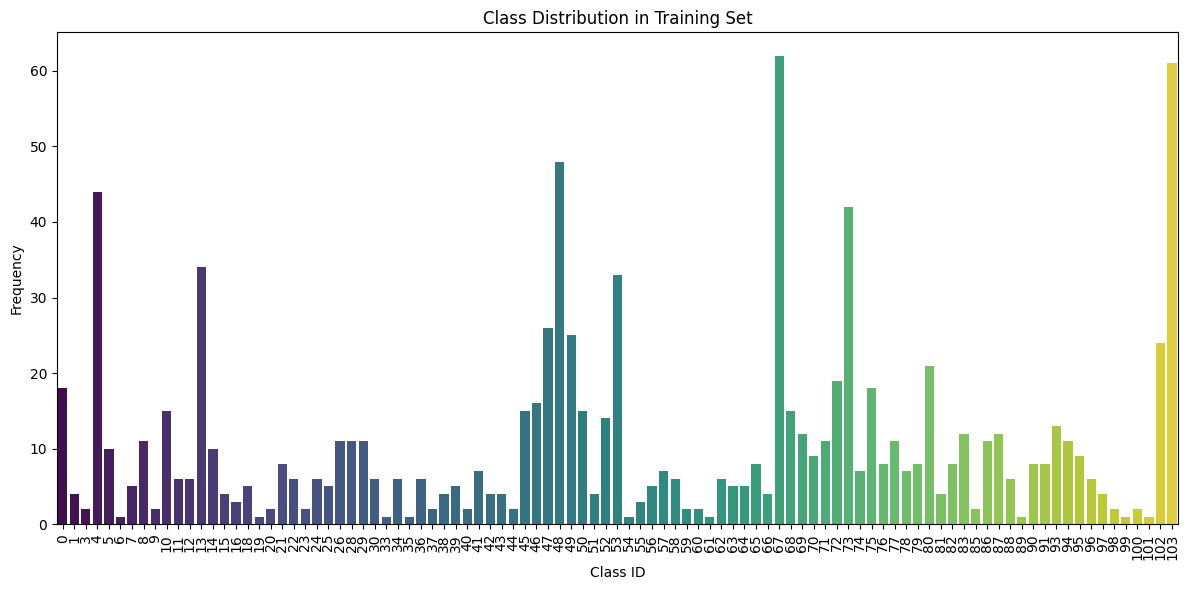

In [6]:
def plot_class_distribution(dataset, num_samples=1000):
    labels = []
    for _, label in dataset.take(num_samples):
        labels.append(int(label))

    plt.figure(figsize=(12,6))
    sns.countplot(x=labels, palette='viridis')
    plt.title("Class Distribution in Training Set")
    plt.xlabel("Class ID")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset)


The class distribution plot shows a highly imbalanced dataset, with a wide variance in the number of samples per class. While some classes (e.g., class IDs around 48, 69, and 103) have over 60 samples, many others—including several in the 30–40 and 90–100 range—have fewer than 5. This skew can significantly impact model performance by biasing learning toward overrepresented classes and reducing generalization on minority classes. Addressing this imbalance will likely require class reweighting, augmentation, or sampling techniques during training.


Image Dimension Check (Box Plot)

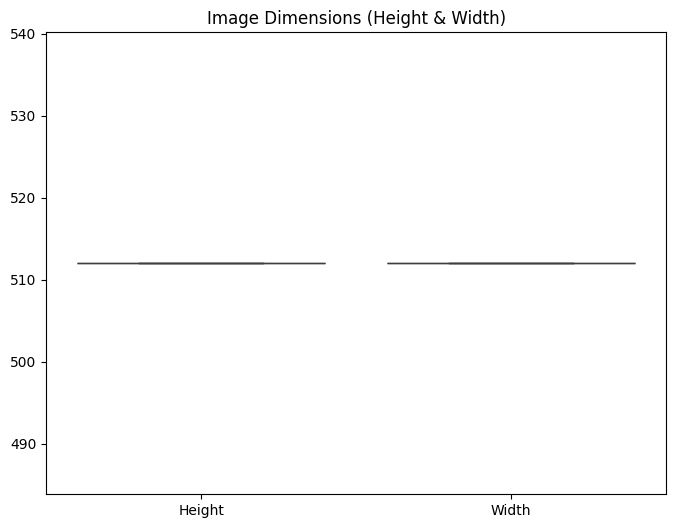

In [7]:
dims = [image.shape[:2] for image, _ in train_dataset.take(200)]
dims_df = pd.DataFrame(dims, columns=["Height", "Width"])

plt.figure(figsize=(8,6))
sns.boxplot(data=dims_df)
plt.title("Image Dimensions (Height & Width)")
plt.show()


The box plot of image dimensions confirms that all images have been successfully standardized to a uniform resolution of 512x512 pixels. Both height and width exhibit no variation, as reflected by the flat lines with no visible interquartile range or outliers. This consistency indicates that the preprocessing step effectively resized all images, eliminating dimension-related variability and ensuring compatibility across the dataset for model training.


Pixel Intensity (RGB) Histogram (Limited as there are so many)

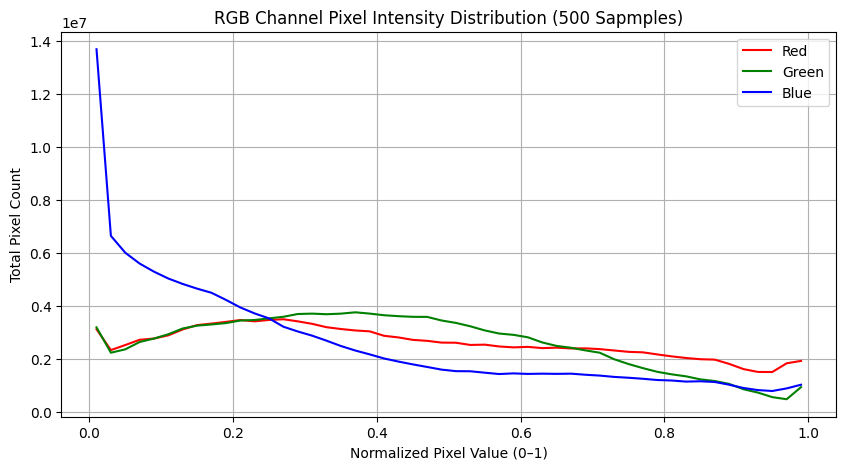

In [8]:


def plot_rgb_histogram_safe(dataset, num_images=20, bins=50):
    # Initialize histograms
    r_hist = np.zeros(bins)
    g_hist = np.zeros(bins)
    b_hist = np.zeros(bins)
    bin_edges = np.linspace(0, 1, bins + 1)

    for i, (image, _) in enumerate(dataset.take(num_images)):
        img = image.numpy()

        r_hist += np.histogram(img[:, :, 0], bins=bin_edges)[0]
        g_hist += np.histogram(img[:, :, 1], bins=bin_edges)[0]
        b_hist += np.histogram(img[:, :, 2], bins=bin_edges)[0]

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.figure(figsize=(10, 5))
    plt.plot(bin_centers, r_hist, color='red', label='Red')
    plt.plot(bin_centers, g_hist, color='green', label='Green')
    plt.plot(bin_centers, b_hist, color='blue', label='Blue')
    plt.title("RGB Channel Pixel Intensity Distribution (500 Sapmples)")
    plt.xlabel("Normalized Pixel Value (0–1)")
    plt.ylabel("Total Pixel Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function on a limited number of images
plot_rgb_histogram_safe(train_dataset, num_images=500)


The RGB channel pixel intensity distribution reveals a notable skew toward lower pixel values, especially in the blue channel, which dominates at the lowest intensities. This suggests that many images contain dark blue or shadowed regions, likely due to natural lighting and background elements in flower photography. In contrast, the red and green channels show a more even spread across mid-range values, indicating greater variation in vegetation and flower coloration. The asymmetry across channels confirms that the dataset contains diverse lighting and background conditions, which the model will need to learn to generalize across.


Sample Image Grid

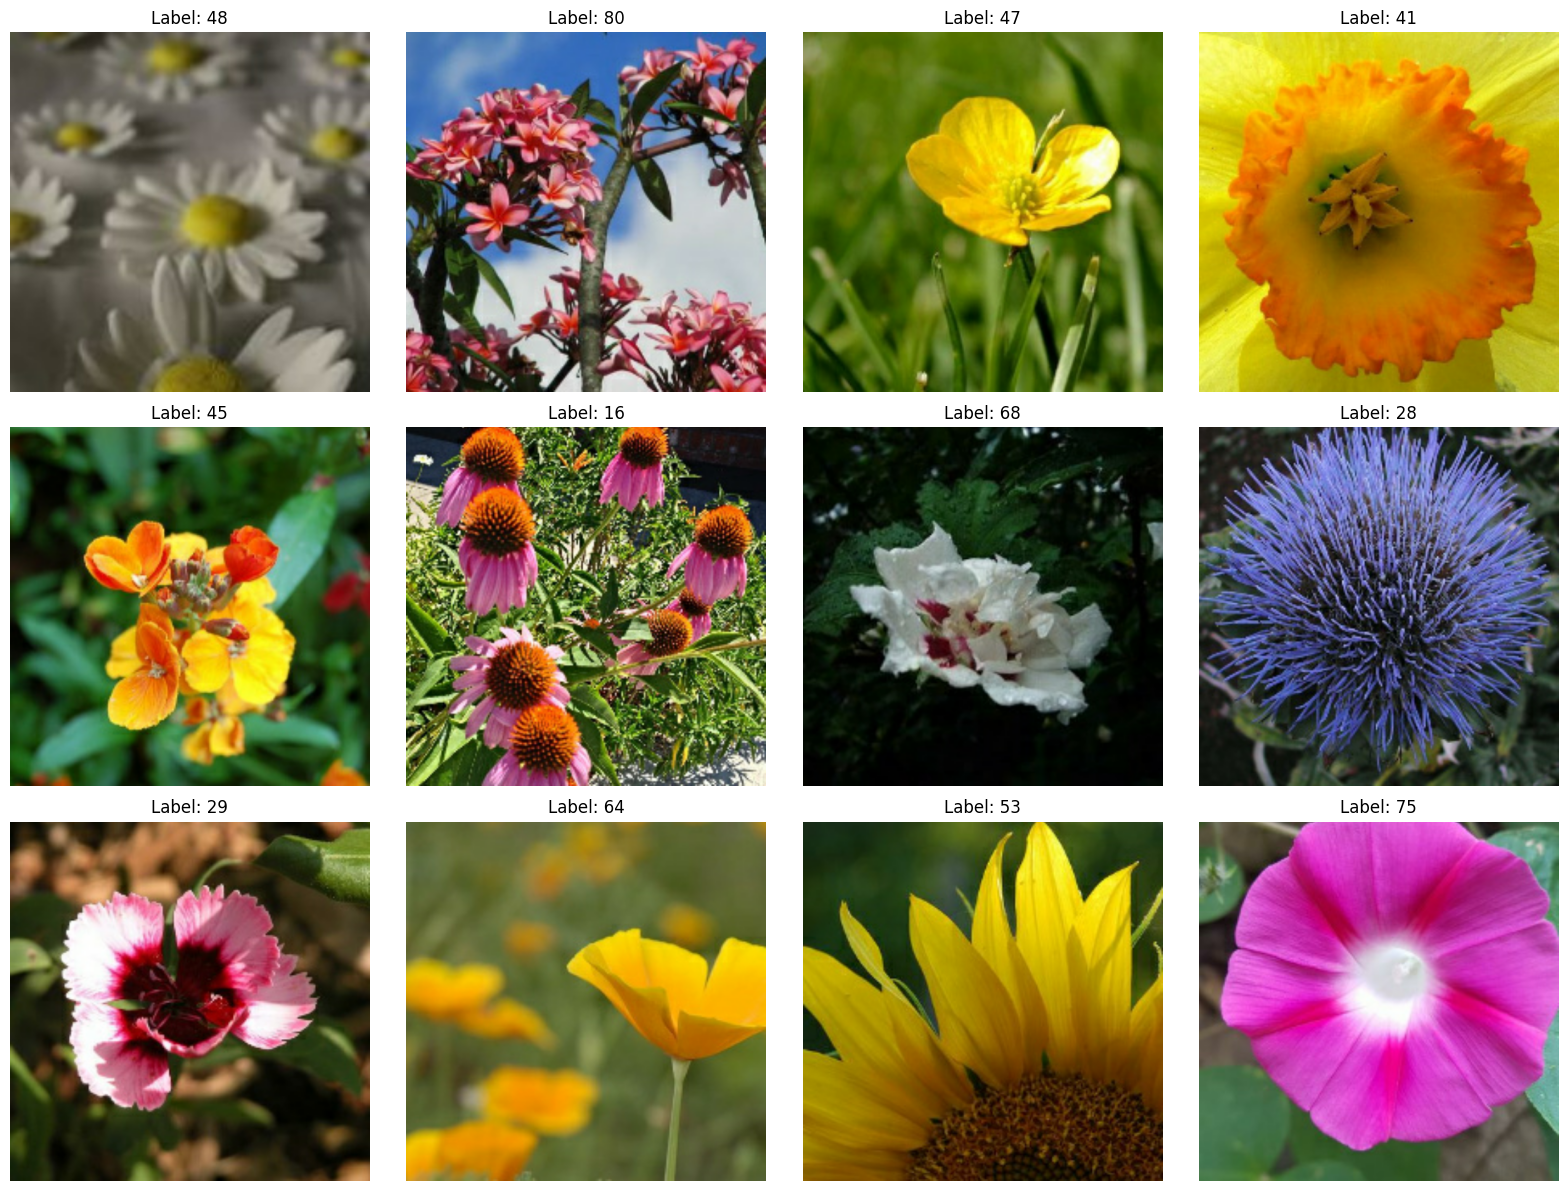

In [9]:
def show_image_grid(dataset, start=0, num=12, cols=4):
    rows = (num + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, (img, label) in enumerate(dataset.skip(start)):
        if i == num:
            break
        plt.subplot(rows, cols, i + 1)
        plt.imshow(tf.cast(img * 255, tf.uint8))
        plt.title(f'Label: {label.numpy()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid(train_dataset, start=0, num=12, cols=4)


The sample image grid highlights the visual diversity present in the dataset, showcasing a wide range of flower types, colors, lighting conditions, and backgrounds. Some flowers are captured with high clarity and centered framing, while others appear in more cluttered or naturalistic settings with varying focus and contrast. This variation reflects the real-world complexity of the data and will challenge the model to generalize across different environmental conditions. The presence of both close-up and distant shots, as well as shadows and background foliage, reinforces the importance of robust feature extraction and potentially data augmentation during training.


Corrupt File Detection

In [5]:
def check_dataset_quality_full(dataset, max_samples=2000):
    """
    Extended quality check for dataset corruption.
    """
    shape_errors = 0
    range_errors = 0
    nan_errors = 0
    total = 0

    for image, label in dataset.take(max_samples):
        total += 1

        # Shape check
        if image.shape != (512, 512, 3):
            shape_errors += 1
            print(f" Shape error at sample {total}: {image.shape}")

        # Range check
        min_val = tf.reduce_min(image).numpy()
        max_val = tf.reduce_max(image).numpy()
        if min_val < 0.0 or max_val > 1.0:
            range_errors += 1
            print(f" Range error at sample {total}: min={min_val}, max={max_val}")

        # NaN check
        if tf.math.reduce_any(tf.math.is_nan(image)):
            nan_errors += 1
            print(f" NaN error at sample {total}")

    print(f"\n Checked {total} samples")
    print(f"Shape issues: {shape_errors}")
    print(f"Pixel range issues: {range_errors}")
    print(f"NaN pixel issues: {nan_errors}")

check_dataset_quality_full(train_dataset, max_samples=2000)




 Checked 2000 samples
Shape issues: 0
Pixel range issues: 0
NaN pixel issues: 0


Above I implemented a quality check across 2,000 samples, verifying that each image had a valid shape (512×512×3), normalized pixel values (0–1), and no NaNs. No corrupted or invalid images were found, confirming the integrity of the dataset post-preprocessing.